# Fanal, a neutrino-less beta decay experiment 

## An open exercise

##  Sentitivity of the experiment

##  Simultaneous fit to control and signal samples

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz

February 2021 - February 2022


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.confint as confint  # Confidence Level functions
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # analysis plotting function specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective:

  * Estudy the sensitivity of the experiment using a frequentist approach, generating many simulated experiments.
  
  * Use a *simultaneous* fit to the signal and controlregion.

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate experiments with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Ensure that the estimation of your signal is correct in different signal scenarios. 
     * Consider for example the case where the signal events are equal to Bi.

   * Estimate the uncertainties on the number of signal events.

   * Study if your experiment will obtain parameters in the *gaussian domain*
   
   * Study the 90% FC CL intervals and the p-value of the $H_0$ hypothesis.

## Notes

  * To valide a fit, usually we generate a large number of experiments with known true parameters; estimate the parameters, and study their distributions.
  
  * In the case of *gaussian domain*, these distributions are gaussian, centered in the true value of the parameters and their standard deviations are the uncertentities of the parameters.
  
  * In the *gaussian domain* we expect the FC variable $t_\mu(x)$ follows a $\chi^2(1)$ distribution.
  
  $$
  t_\mu(x) = -2 \mathrm{log} \frac{\mathcal{L}({\bf x}| \mu, \hat{\nu})}{\mathcal{L}({\bf x}| \hat{\mu}, \hat{\nu})}
  $$

## Main parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [6]:
# list of the analisys selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E']
varranges = [ntracks_range, eblob2_range, erange]
print('analysis varnames   : ', varnames)
print('analysis varranges  : ', varranges)

# list of the reference selction variable names and rages to get pdfs for the MC
refnames  = ['num_tracks', 'E']
refranges = [ntracks_range, erange]
print('reference varnames  : ', refnames)
print('reference varranges : ', refranges)

# list of the control selection variable names and rages to get pdfs for the MC
connames  = ['num_tracks', 'E']
conranges = [(2, 20), erange]
print('control varnames    : ', connames)
print('control varranges   : ', conranges)


analysis varnames   :  ['num_tracks', 'blob2_E', 'E']
analysis varranges  :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7)]
reference varnames  :  ['num_tracks', 'E']
reference varranges :  [(1, 1.1), (2.4, 2.7)]
control varnames    :  ['num_tracks', 'E']
control varranges   :  [(2, 20), (2.4, 2.7)]


In [7]:
# number of  blind events
nevts_Bi = collpars.nevts_Bi
nevts_Tl = collpars.nevts_Tl
print('Number of bkg events in full data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(nevts_Bi, nevts_Tl))

Number of bkg events in full data : Bi = 1403.27, Tl = 20673.20.


## Access the data

In [8]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

mcs      = [mcbb, mcbi, mctl]
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$',r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


## Check method with a mc experiment

  * Generate a MC experiments with number of events compatible with estimated number of bkg events and a hipothetical number of signal events.
  
  * Fit the energy distribution of the selected events to the thress samples pdfs: bb, Bi. Tl
  
  * Do a profile scan to estimate the confidence interval and p0-value for this example

**Exercise**:

  * Generate other experiments with different number of signal events to study the performance of the fit

In [9]:
def nevts_total(factor = 1.):
    """ Compute the number of total events
        Assumes that the number of signal in RoI is a factor of  number of Bi en RoI.
    """
    nevts_Bi_RoI    = collpars.nevts_Bi_RoI
    eff_bb_RoI      = collpars.eff_bb_RoI
    nevts           = (factor * nevts_Bi_RoI / eff_bb_RoI, nevts_Bi, nevts_Tl)
    return np.array(nevts)

## Generate experiments

  * Generate m experiments with the same number of expected events.
  
  * Study if the estimated number of events for each sample follows a gaussian distribution
  
  * Test the the $t_\mu$ variable for the signal is $\chi^2(1)$ distributed.
  
  * Compute the mean p0-value for the null hypothesis


In [10]:
nevts      = nevts_total(1.)
experiment = fn.prepare_experiment_simell(mcs, nevts, varnames, varranges,
                                          refnames, refranges, connames, conranges)

In [11]:
success, mcdata, eres = experiment()
print('experiment success ? ', success)
print('experimetn result = ', eres)

experiment success ?  True
experimetn result =  ExpResult(nbb=17.373983536604147, nBi=25.87603502245962, nTl=150.98234505980096, nbb0=21.75092609805476, nBi0=25.25160329988037, nTl0=150.84615243482804, tmun=0.9549885840242496, tmu=0.6838397271858412, qmu=0.6838397271858412, q0=31.694602490482794)


**Attention**: generating experiment can be slow...

In [12]:
df = fn.run(experiment, size = 300)

In [13]:
df

,nbb,nBi,nTl,nbb0,nBi0,nTl0,tmun,tmu,qmu,q0
0,22.861136,25.375400,152.043276,21.750926,25.251603,150.846152,0.961437,0.041838,0.000000,49.410766
1,15.923310,26.256777,151.995990,21.750926,25.251603,150.846152,2.931174,1.195589,1.195589,23.904983
2,22.669483,25.375588,152.026535,21.750926,25.251603,150.846152,0.915912,0.024253,0.000000,44.711589
3,19.867507,24.759612,152.652898,21.750926,25.251603,150.846152,1.963431,0.118919,0.118919,33.940799
4,18.306762,24.677605,148.931965,21.750926,25.251603,150.846152,3.303281,0.415835,0.415835,34.582875
...,...,...,...,...,...,...,...,...,...,...
295,24.388822,24.873578,150.617719,21.750926,25.251603,150.846152,0.352121,0.215970,0.000000,47.964250
296,15.162867,24.625388,152.697374,21.750926,25.251603,150.846152,3.502628,1.478598,1.478598,20.552198
297,21.190433,26.176753,150.414387,21.750926,25.251603,150.846152,0.639319,0.011113,0.011113,41.252133
298,6.734666,26.964925,151.643025,21.750926,25.251603,150.846152,9.955050,7.776572,7.776572,4.268483


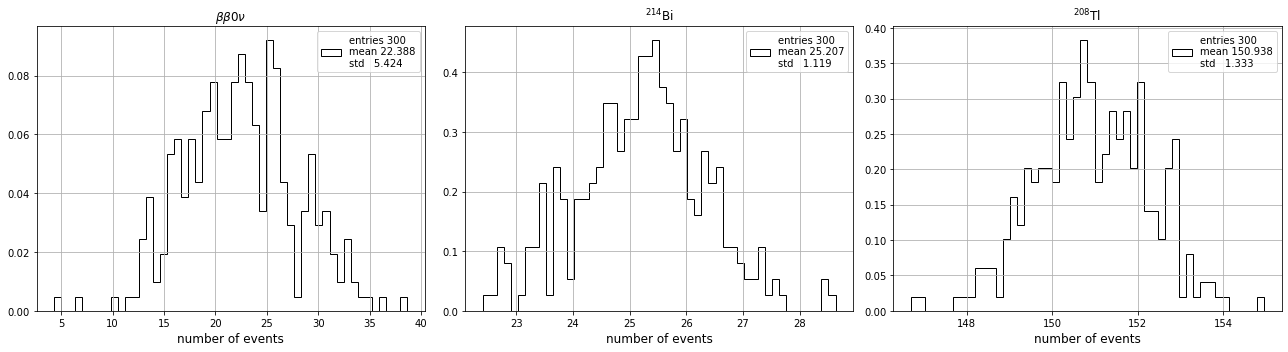

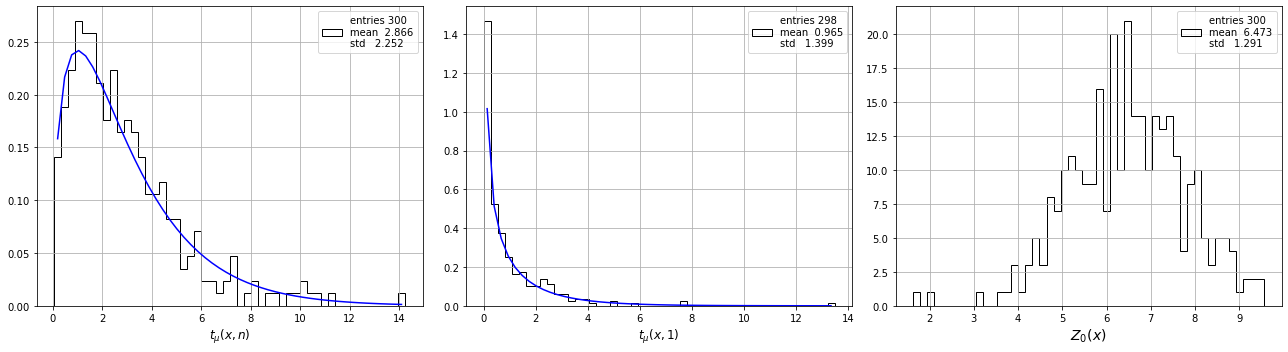

In [14]:
pltfn.plot_nevts((df.nbb, df.nBi, df.nTl))
pltfn.plot_gaus_domain(df.tmun, df.tmu, df.q0)

### Run several experiments with different number of signal events

In [15]:
def tau(nbb, taumax = 3e27):
    acc_bb   = collpars.acc_bb
    eff      = collpars.eff_bb_RoI
    exposure = collpars.exposure
    tau      = fn.half_life(nbb, exposure, acc_bb * eff)
    tau[tau > taumax] = taumax
    return tau

In [16]:
size = 100
dfs  = [] 
for factor in (1.25, 1., 0.5, 0.25, 0.):
    nevts = nevts_total(factor)
    print(' generating {:4.2f}, {:6.2f}, {:6.2f} events, {:d} experiments'.format(*nevts, size))
    experiment = fn.prepare_experiment_simell(mcs, nevts, varnames, varranges,
                                             refnames, refranges, connames, conranges)
    df = fn.run(experiment, size)
    dfs.append(df)

 generating 52.39, 1403.27, 20673.20 events, 100 experiments
 generating 41.91, 1403.27, 20673.20 events, 100 experiments
 generating 20.95, 1403.27, 20673.20 events, 100 experiments
 generating 10.48, 1403.27, 20673.20 events, 100 experiments
 generating 0.00, 1403.27, 20673.20 events, 100 experiments


In [17]:
for df in dfs:
    df['tau']  = tau(df.nbb)
    df['tau0'] = tau(df.nbb0)

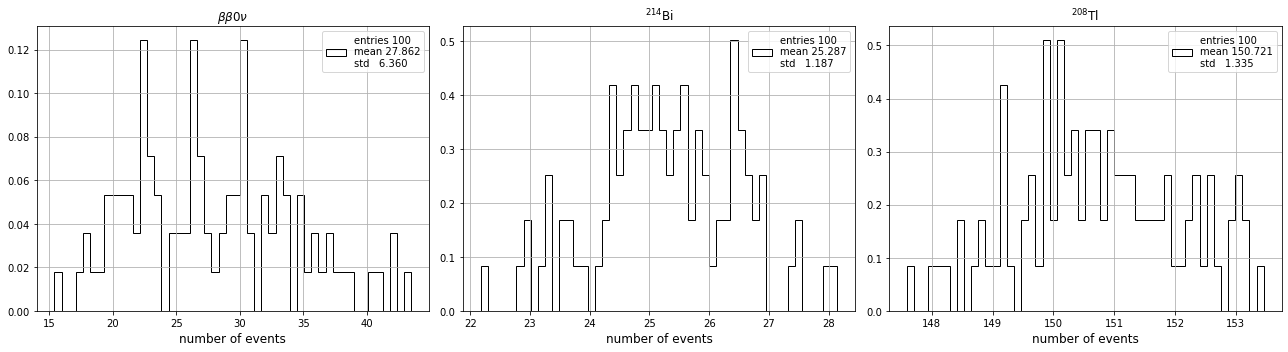

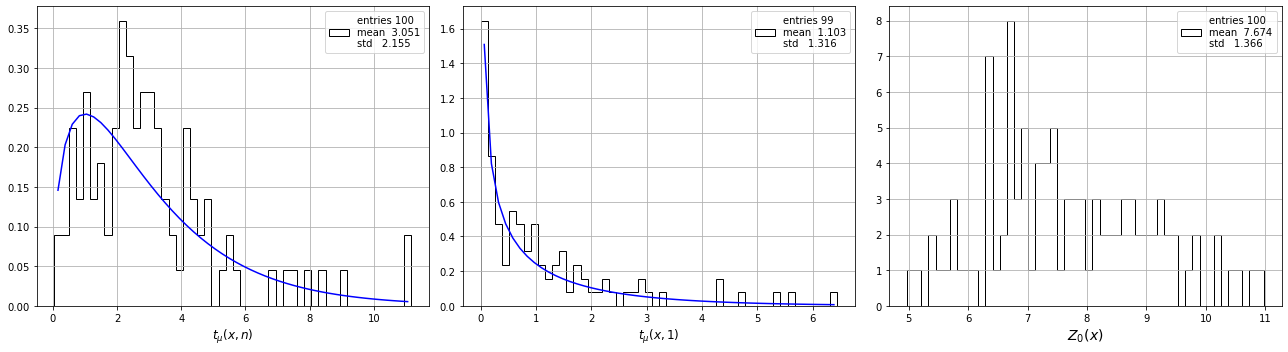

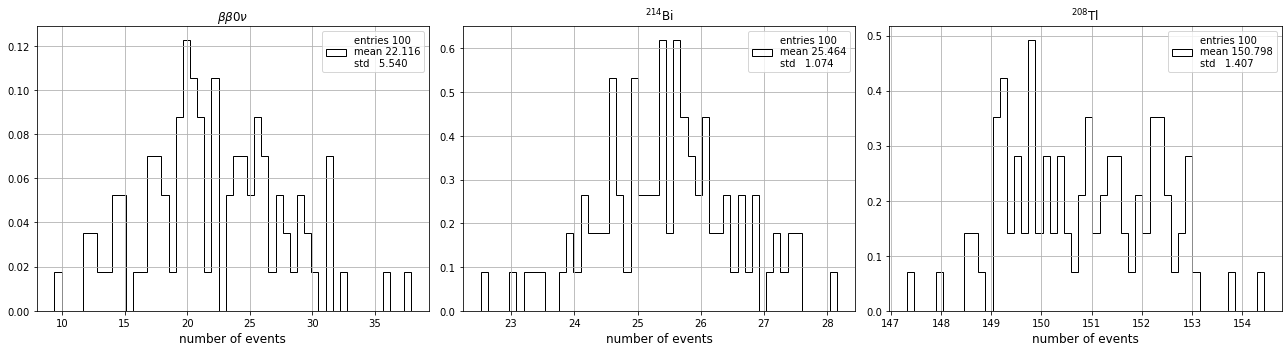

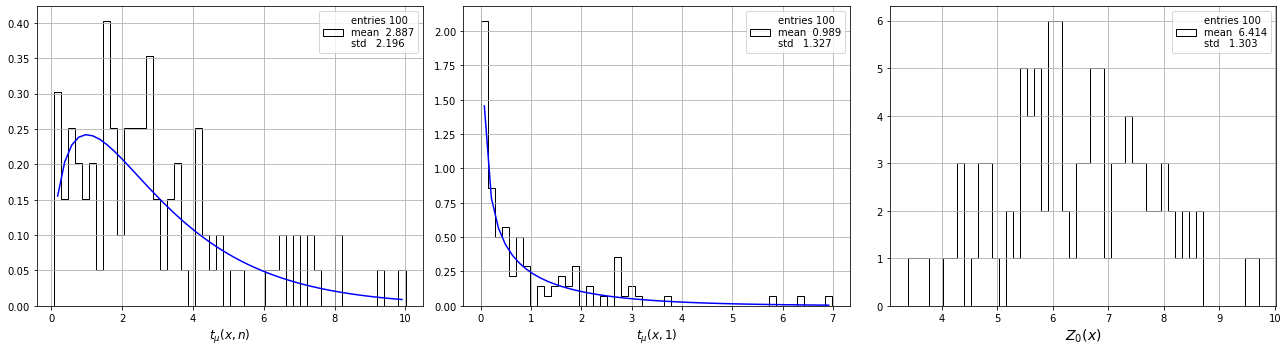

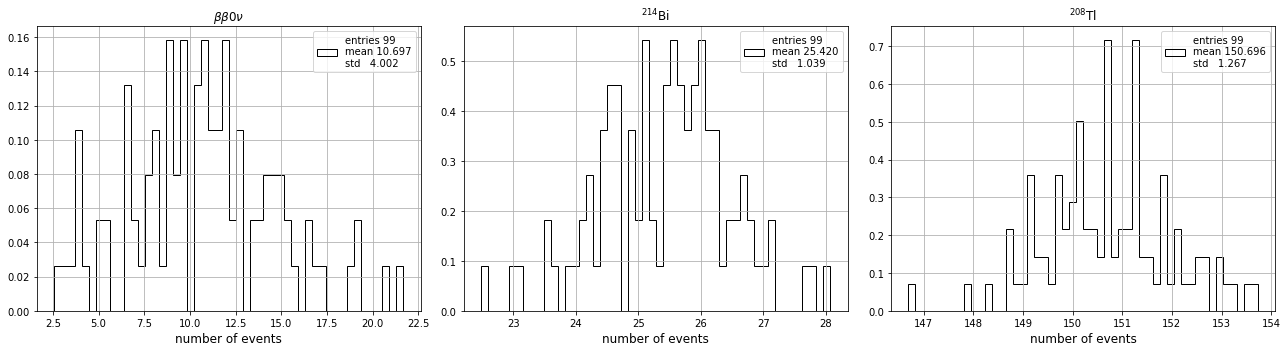

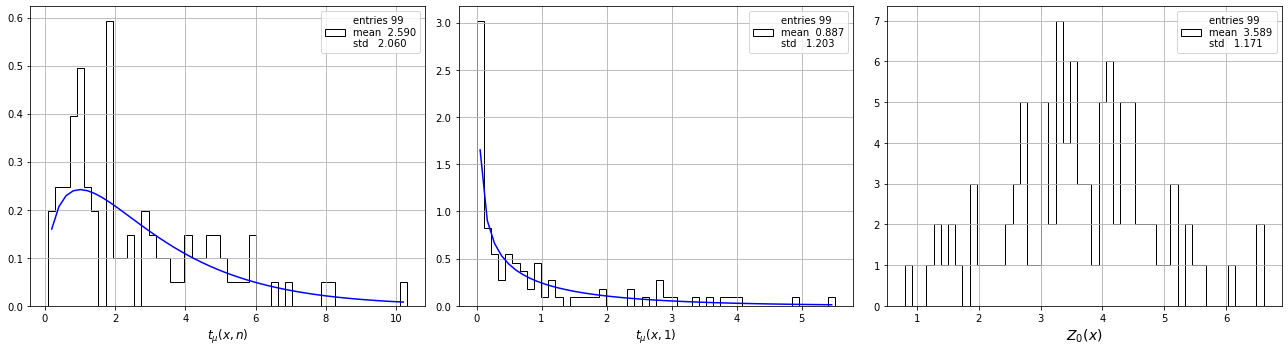

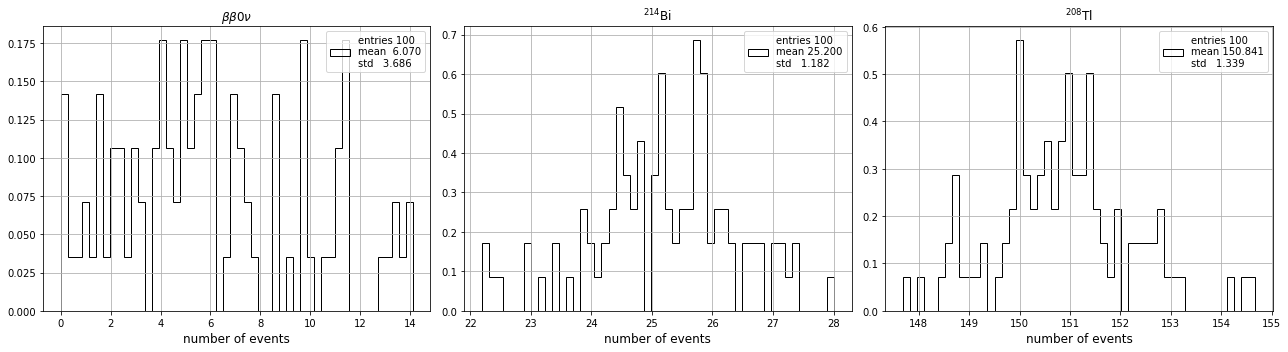

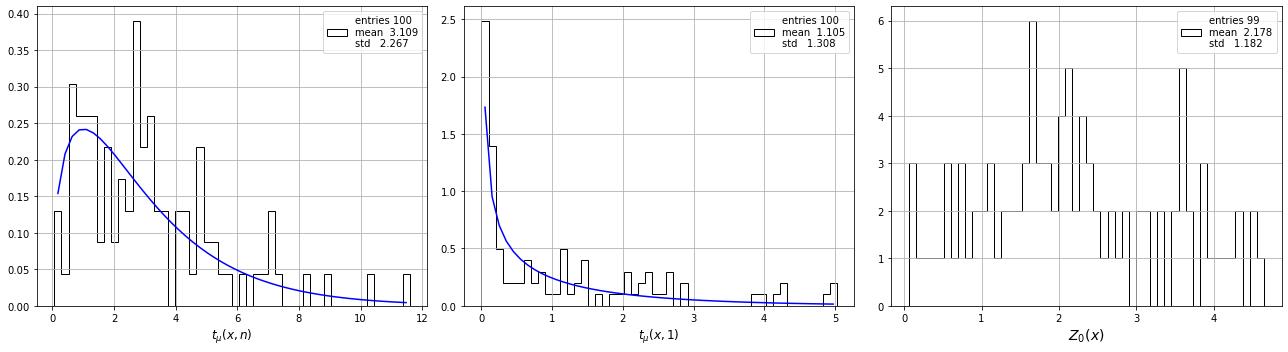

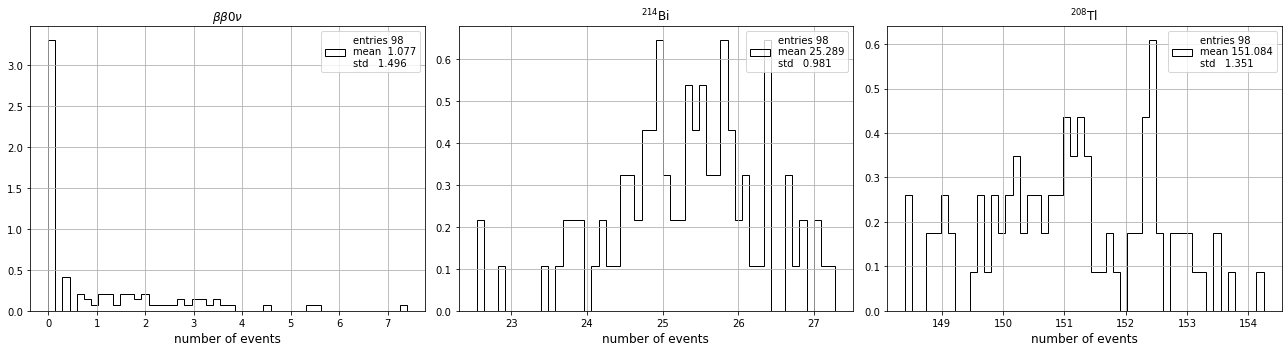

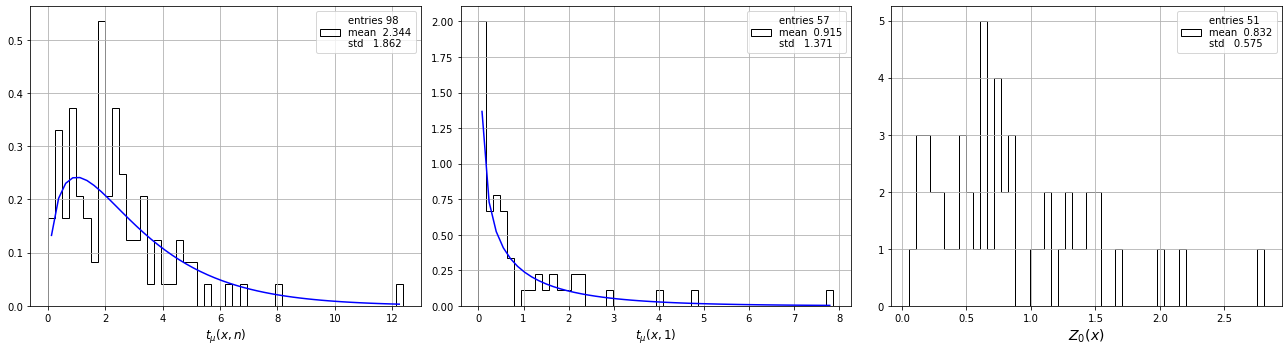

In [18]:
for df in dfs:
    pltfn.plot_nevts((df.nbb, df.nBi, df.nTl))
    pltfn.plot_gaus_domain(df.tmun, df.tmu, df.q0)

### Feldman Cousins CL

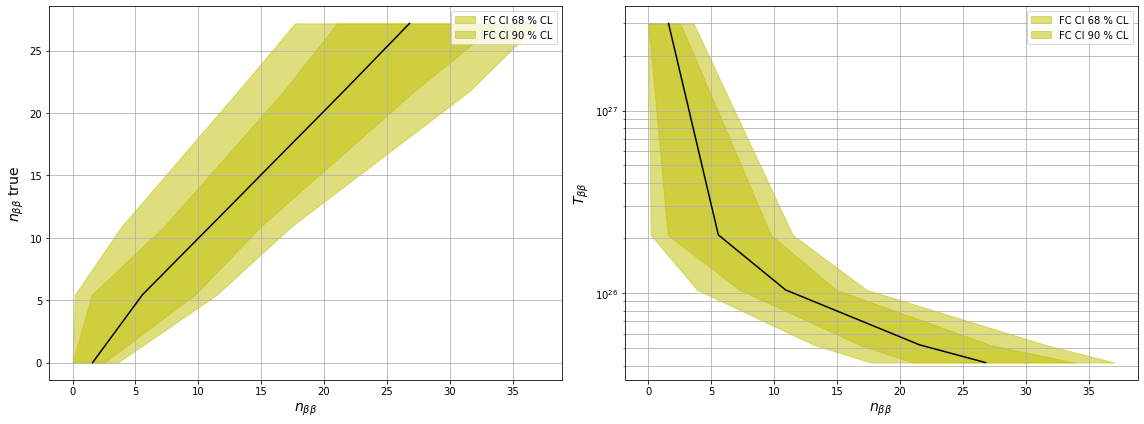

In [19]:
pltfn.plot_exps_fc_confint(dfs)

### Null Hypothesis Z sigmas

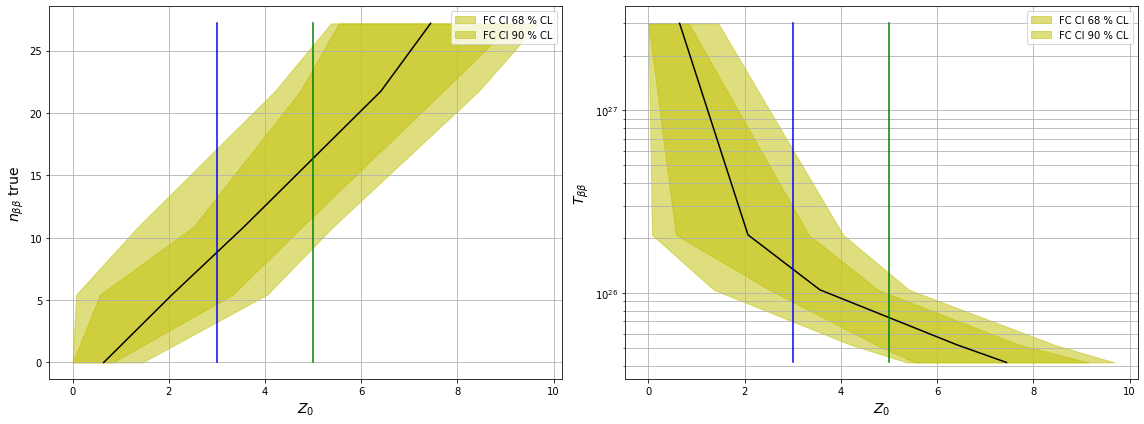

In [20]:
pltfn.plot_exps_z0(dfs)

## Appendix: step by step

In [23]:
varname = 'E'
def experiments(nevts, size = 1):
    
    # expected number of events for each mc sample
    effs_signal     = np.array([ut.selection_efficiency(mc, varnames, varranges)[0] for mc in mcs])
    effs_control    = np.array([ut.selection_efficiency(mc, connames, conranges)[0] for mc in mcs])
    nevts_signal    = effs_signal * nevts
    factor_control  = effs_control/effs_signal

    
    # generate the ELL instace to fit the energy distribution to the energy distribution of the three mc samples
    ell_signal  = fn.get_ell(mcs, refnames, refranges)
    ell_control = fn.get_ell(mcs, connames, conranges)
    ell         = efit.SimulExtComPDF(ell_signal, ell_control, factor_control)

    res = []
    for i in range(int(size)):
        
        # generate an experiment using the mc samples and a given number of events of each sample
        mcdata  = fn.generate_mc_experiment(mcs, nevts)
        
        mcdata_signal  = ut.selection_sample(mcdata, varnames, varranges)
        mcdata_control = ut.selection_sample(mcdata, connames, conranges)
        values = [x[varname].values for x in (mcdata_signal, mcdata_control)]

        # fit the energy values of the data 
        result         = ell.best_estimate(values, *nevts_signal)
        if (result.success == False): continue

        nevts_est      = result.x
        tmuvals        = fn.tmu_values(values, nevts_est, ell, nevts_signal)

        res.append(fn.ExpResult(*nevts_est, *nevts_signal, *tmuvals))
    
    res = ut.list_transpose(res)
    df  = ut.list_to_df(res, fn.ExpResult._fields) 
    return df

In [24]:
nevts = nevts_total(1.)
df    = experiments(nevts, 10)

In [25]:
df

,nbb,nBi,nTl,nbb0,nBi0,nTl0,tmun,tmu,qmu,q0
0,16.434797,24.978364,150.642406,21.750926,25.251603,150.846152,1.105822,0.946734,0.946734,23.944224
1,22.688931,24.622173,151.331721,21.750926,25.251603,150.846152,0.364621,0.027960,0.000000,41.811384
2,22.319243,24.477304,148.826254,21.750926,25.251603,150.846152,3.406964,0.010422,0.000000,46.178448
3,17.842375,27.298748,150.252115,21.750926,25.251603,150.846152,3.264105,0.472633,0.472633,24.731806
4,12.473905,27.306821,150.992228,21.750926,25.251603,150.846152,6.004751,3.201984,3.201984,15.997264
5,31.737197,26.043618,152.430563,21.750926,25.251603,150.846152,5.489576,2.804659,0.000000,69.930779
6,27.975731,24.361178,151.168512,21.750926,25.251603,150.846152,1.718883,1.243430,0.000000,67.326304
7,16.567217,24.200289,150.717294,21.750926,25.251603,150.846152,2.044090,0.976208,0.976208,27.686504
8,20.464935,25.225333,152.732165,21.750926,25.251603,150.846152,2.128024,0.059284,0.059284,35.133714
9,30.828933,24.278938,152.646705,21.750926,25.251603,150.846152,4.319916,2.376753,0.000000,70.243379
